In [5]:
# Design specifications and material properties

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import fsolve


# Fuel assembly (FA) representative of average core conditions
P_FA = 6.641 #[MW] Fuel assembly thermal power
N_FP = 284 #[pin] Number of fuel pins in the fuel assembly
q_l0 = 26.03 #[kW/m] Linear heat rate at fuel midplane, q'(0)
pitch = 13.6 #[mm] Pin pitch
T_co_in = 400 #[°C] Coolant inlet temperature
T_co_out = 480 #[°C] Coolant outlet temperature

# Coolant properties (uniform along the channel) - Liquid Pb
cp_co = 146 #[J/kg-°C] Average heat capacity
rho_co = 10520 #[kg/m^3] Average density
mu_co = 0.002 #[Pa-s] Average dynamic viscosity
k_co = 15.5 #[W/m-°C] Average thermal conductivity

# Fuel pins
D_clad_ext = 8.50 #[mm] External diameter of cladding
t_clad = 0.600 #[mm] Cladding thickness
H_act = 1100 #[mm] Active length
H_tot = 2100 #[mm] Total length

# Fuel - solid pellets (MOX)
TD_fuel = 11.31 #[g/cm^3] Theoretical density of MOX fuel
rho_fuel = 0.88*TD_fuel #[g/cm^3] Density of fuel
T_fuel_melt = 2730 #[°C] Melting temperature of fresh fuel
D_fuel = 6.98 #[mm] Fuel pellet diameter
alpha_l_fuel = 12e-6 #[°C^-1] Linear coefficient of thermal expansion (T_ref = 25°C)
Y_fuel = 170 #[GPa] Young's modulus of solid pellets
nu_poisson_fuel = 0.31 #[/] Poisson's coefficient

# Cladding - Ferritic-martensitic steel T91 (UNS No. K90901)
T_clad_melt = 1500 #[°C] Melting temperature of cladding
k_clad = 28.7 #[W/m-°C] Average thermal conductivity of cladding
alpha_l_clad = 12e-6 #[°C^-1] Linear coefficient of thermal expansion (T_ref = 25°C)
Y_clad = 170 #[GPa] Young's modulus of cladding
nu_poisson_clad = 0.3 #[/] Poisson's coefficient
#SY_clad = 563.1 - 4.878e-1*T_clad + 1.6e-3*T_clad**2 - 3e-6*T_clad**3 + 8e-10*T_clad**4 #[MPa] Yield strength of cladding

In [6]:
# COLD GEOMETRY ANALYSIS
# (I)

# Coolant mass flowrate  (square channel 1/4*4 fuel pins = 1 fuel pin)
P_FP = P_FA/N_FP #[MW/pin] Average thermal power per fuel pin
m_co = P_FP/(cp_co*(T_co_out - T_co_in))*1e6 #[kg/s] Average coolant mass flowrate per channel
volflow_co = m_co/rho_co #[m^3/s] Average volumetric flow of coolant per channel
print('Average thermal power per fuel pin:',P_FP,'[MW/pin]')
print('Average coolant mass flowrate per channel:',m_co,'[kg/s]')

# Geometry of channel
A_channel = pitch**2-(np.pi*D_clad_ext**2/4) #[mm^2] Area channel
P_w = np.pi*D_clad_ext #[mm] Wet perimeter
D_h = 4*A_channel/P_w/1000 #[m] Hydraulic diameter of channel
print('Hydraulic diameter of channel:',D_h, '[m]')

# Calculation of velocity of coolant in channel
v_co = volflow_co/(A_channel/1e6) #[m/s] Average velocity of coolant in channel
print('Average velocity of coolant in channel',v_co,'[m/s]')

# Reynolds number of coolant
Re_co = rho_co*v_co*D_h/mu_co #[/]
print('Reynolds number of coolant:', Re_co)

# Darcy factor
f_darcy=0.184*Re_co**(-0.20)
print('Darcy factor of coolant per channel:', f_darcy)

# Calculation of Prandtl number
Pr_co = mu_co*cp_co/k_co #[/]
print('Prandtl number of coolant:', Pr_co)

# Calculation of Peclet number
Pe_co = Re_co*Pr_co #[/]
print('Peclet number of coolant:', Pe_co)

# Calculation of Nusselt number
x = pitch/D_clad_ext #[/] Pin-pitch to cladding outer diameter ratio
print('Pin-pitch to cladding outer diameter ratio:', x)
Nu_co_1 = 0.58*(D_h/(D_clad_ext/1000))**0.55*Pe_co**0.45 #discarded x value out of range
Nu_co = 4.5 + 0.014*Pe_co**0.8
print('Nusselt1 number of coolant:', Nu_co_1)
print('Nusselt number of coolant:', Nu_co)

# Heat transfer coefficient of coolant
h_co = Nu_co*k_co/D_h #[W/m^2-°C]
print('Heat transfer coefficient of coolant:', h_co, '[W/m^2-°C]')

Average thermal power per fuel pin: 0.02338380281690141 [MW/pin]
Average coolant mass flowrate per channel: 2.0020379124059424 [kg/s]
Hydraulic diameter of channel: 0.01920569249343714 [m]
Average velocity of coolant in channel 1.4842866438142674 [m/s]
Reynolds number of coolant: 149945.52000789868
Darcy factor of coolant per channel: 0.01696801830703975
Prandtl number of coolant: 0.018838709677419355
Peclet number of coolant: 2824.7801188584785
Pin-pitch to cladding outer diameter ratio: 1.5999999999999999
Nusselt1 number of coolant: 32.439724710137625
Nusselt number of coolant: 12.570784551614757
Heat transfer coefficient of coolant: 10145.281697945067 [W/m^2-°C]


In [7]:
# COLD GEOMETRY ANALYSIS
# (II)

# Average linear heat rate
q_l_av = P_FP*1000/(H_act/1000) #[kW/m]
print('Average linear heat rate', q_l_av, '[kW/m]')

# Axial linear heat rate distribution [kW]
def q_l(z, H_ext):
    return q_l0 * np.cos(np.pi * z / H_ext)

# Average power per half fuel pin
int_q_l = (P_FP*1000)/2 #[kW] Integral from z=0 to z=H_act/2 + H_ext is equal to the half of average power of 1 fuel pin
print('Fuel power of half pin fuel:',int_q_l,'[kW]')

# Define a function for the integral and the target value
def integral_eq(H_ext):
    # Compute the integral of q_l from 0 to H_ext
    integral, _ = quad(q_l, 0, (H_act+H_ext)/(2*1000), args=(H_ext,))
    return integral - int_q_l  # Return the difference from the target value

# Use fsolve to solve for H_ext that satisfies the integral equation
H_ext_solution = fsolve(integral_eq, 1.0)  # Initial guess for H_ext

print(f"Calculated H_ext: {H_ext_solution[0]}", "[m]")

Average linear heat rate 21.25800256081946 [kW/m]
Fuel power of half pin fuel: 11.691901408450704 [kW]
Calculated H_ext: 1.5969497677149038 [m]


In [15]:
# Verification of extrapolated length
H_ext = H_ext_solution[0]
z = (H_act + H_ext)/(2*1000)

a = np.cos(np.pi * z)/H_ext #a should be zero
print(f"Cos(***): {a}")

# Axial linear heat rate distribution [kW]
def q_l2(z):
    return q_l0 * np.cos(np.pi * z / H_ext)

# Evaluate the function at different values of z
z1 = 0
z2 = (H_act + H_ext)/(2*1000)

print(f"q_l2(z = {z1} [mm]) = {q_l2(z1)} [kW/m]")  #corresponds to qo given
print(f"q_l2(z = {z2} [mm]) = {q_l2(z2)} [kW/m]")  #should be 0 in the extrapolated border

# Calculate the integral from 0 to 2
result, error = quad(q_l2, 0, H_act/2 + H_ext)

print('Average thermal power per fuel pin:',P_FP*1000,'[kW/pin]')
print("Integral result:", 2*result,'[kW/pin]')
print("Estimated error:", error)

Cos(***): -0.099509435247697
q_l2(z = 0 [mm]) = 26.03 [kW/m]
q_l2(z = 0.5507984748838575 [mm]) = 12.186964410871516 [kW/m]
Average thermal power per fuel pin: 23.383802816901408 [kW/pin]
Integral result: -24.197838106426225 [kW/pin]
Estimated error: 355.4456790949672


<ipython-input-15-4a47add8ddfb>:20: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, error = quad(q_l2, 0, H_act/2 + H_ext)


Outer cladding temperature: 536.0818284974699 [°C]
Inner cladding temperature: 556.4604462569225 [°C]


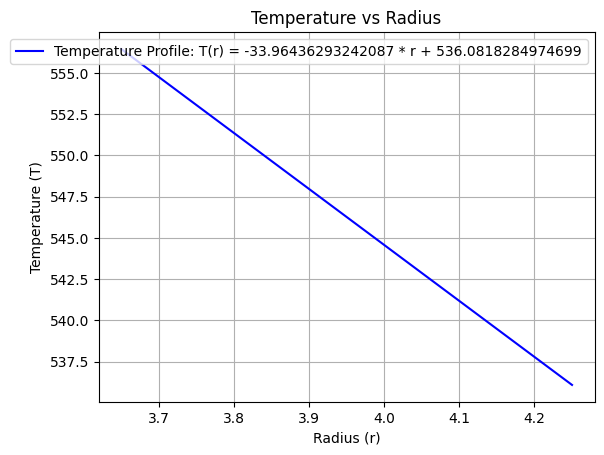

In [9]:
# Radial temperature profile at midplane

# Outer cladding temperature
T_co_avg0 = (T_co_in+T_co_out)/2 #[°C] Average temperature of coolant along the channel
T_clad_out = (q_l0*1e6/P_w)/h_co + T_co_avg0 #[°C] Outer cladding temperature
print('Outer cladding temperature:', T_clad_out, '[°C]')

# Define the constant value
dTdr_clad = -(q_l0*1e3)/(P_w*k_clad)  # Change this to your desired constant value

# Define the initial condition
r_clad_out = D_clad_ext/2 #[mm] External radius of cladding
T_clad_out = T_clad_out #[°C] Initial temperature of cladding at r_clad0

# Define the range of r values
r_values = np.linspace(r_clad_out-t_clad, r_clad_out, 100)  #values along cladding thickness

# Solve the differential equation
C = T_clad_out - dTdr_clad * r_clad_out  # Solve for constant C
T_values = dTdr_clad * r_values + C  # Compute temperature values

# Inner cladding temperature
r_clad_in = r_clad_out - t_clad #[mm] Internal radius of cladding
T_clad_in = dTdr_clad * r_clad_in + C
print('Inner cladding temperature:',T_clad_in, '[°C]')

# Plot the results
plt.plot(r_values, T_values, label=f'Temperature Profile: T(r) = {dTdr_clad} * r + {T_clad_out}', color='blue')
plt.title('Temperature vs Radius')
plt.xlabel('Radius (r)')
plt.ylabel('Temperature (T)')
plt.grid()
plt.legend()
plt.show()

In [10]:
# HOT GEOMETRY ANALYSIS

# Radial temperature profile in fuel pin

theta_gas = (T_gas_fuel + T_gas_clad)/2 #[°C] Average temperature of Helium
k_gas = 15.8e-4*theta_gas**0.79 #[W/m-K] Thermal conductivity of Helium



NameError: name 'T_gas_fuel' is not defined